In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skesn.esn import EsnForecaster
from thequickmath.field import Space, map_to_2d_mesh

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from skesn.cross_validation import ValidationBasedOnRollingForecastingOrigin
from skesn.weight_generators import optimal_weights_generator

In [3]:
def plot_data(data_num, u_v_part=2, save=False):
    filename = 'C:\\Users\\njuro\\Documents\\restools\\Researches\\2022-07-26-predicting-brusselator-via-esn\\1-Dataset_from_Calum_1D_Brusselator\\brusselator1DB_%s.npz' %data_num
    data = np.load(filename)

    x = data['x']
    u = data['u']
    v = data['v']
    t = data['t']

    plt.pcolormesh(x, t, u, shading='nearest',cmap='plasma')
    plt.colorbar()
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$t$', fontsize=16)
    plt.tight_layout()
    plt.ylim([175,200])
    if save == True:
        plt.savefig("C:\\Users\\njuro\\Documents\\Диплом Магистратура\\Figures\\1D_bru_images_note_08_13\\u_colormesh_%s.png" %data_num)
    plt.show()

    plt.plot(u[:,u_v_part],v[:,u_v_part])
    plt.xlabel(r'$u$', fontsize=16)
    plt.ylabel(r'$v$', fontsize=16)
    if save == True:
        plt.savefig("C:\\Users\\njuro\\Documents\\Диплом Магистратура\\Figures\\1D_bru_images_note_08_13\\phase_tr_%s.png" %data_num)
    plt.show()

### подготовка данных

In [4]:
#перевести v из(18001,384) в (18001, 256)
filename = 'C:\\Users\\njuro\\Documents\\restools\\Researches\\2022-07-26-predicting-brusselator-via-esn\\1-Dataset_from_Calum_1D_Brusselator\\brusselator1DB_2.npz' 
def get_data(filename, plot=True):
    data = np.load(filename)
    data.files
    x = data['x']
    t = data['t']
    u = data['u']
    v = data['v']
    #plot_data('2')
    x_space = Space((t,x))
    x_384 = np.linspace(x[0], x[-1], v.shape[1])
    v_space = Space((t,x_384)) #range(v.shape[1])
    v_new= map_to_2d_mesh(v, v_space, x_space)
    print(v.shape, v_new.shape)
    if plot:
        #проверяем:
         #поле u
        plt.pcolormesh(x, t, u, shading='nearest',cmap='plasma')
        plt.colorbar()
        plt.xlabel(r'$x$', fontsize=16)
        plt.ylabel(r'$t$', fontsize=16)
        plt.tight_layout()
        #plt.ylim([175,200])
        plt.show()
         #поле v_new
        plt.pcolormesh(x, t, v_new, shading='nearest',cmap='plasma')
        plt.colorbar()
        plt.xlabel(r'$x$', fontsize=16)
        plt.ylabel(r'$t$', fontsize=16)
        plt.tight_layout()
        #plt.savefig("C:\\Users\\njuro\\Documents\\Диплом Магистратура\\Figures\\1D_bru_images_note_08_14\\v_new_mesh.png")
        plt.show()
    return x, t, u, v_new
x, t, u, v_new = get_data(filename, plot=False)

(18001, 384) (18001, 256)


In [32]:
#объединение u и v в один массив
u_v_concat = np.zeros((u.shape[0], u.shape[1]+v_new.shape[1]))
print(u_v_concat.shape)
u_v_concat[:,:256] = u
u_v_concat[:,256:] = v_new

(18001, 512)


In [33]:
#t=0.01
#::2 t=0.02
t_miss = 1
u_v_concat=u_v_concat[::t_miss,:]
print(u_v_concat.shape)

(18001, 512)


### подготовка данных закончена

## ESN 

In [13]:
#ESN
rand=10
np.random.seed(rand)
esn_bru_uv = EsnForecaster(n_reservoir=1500,
                           spectral_radius=0.95,
                           sparsity=0.2,
                           regularization='noise',
                           lambda_r=0.005,
                           in_activation='tanh',
                           out_activation='identity',
                           use_additive_noise_when_forecasting=True,
                           random_state=rand,
                           use_bias=True) 
print(esn_bru_uv)

EsnForecaster(lambda_r=0.005, n_reservoir=1500, random_state=10, sparsity=0.2)


In [34]:
#ESN стандартная
rand=10
np.random.seed(rand)
esn_bru_uv = EsnForecaster(n_reservoir=1500,
                           spectral_radius=0.95,
                           sparsity=0,
                           regularization='noise',
                           lambda_r=0.001,
                           in_activation='tanh',
                           out_activation='identity',
                           use_additive_noise_when_forecasting=True,
                           random_state=rand,
                           use_bias=True) 
print(esn_bru_uv)

EsnForecaster(n_reservoir=1500, random_state=10)


In [35]:
time_train = 10000
train_data_uv = np.array(u_v_concat[:time_train,:])
print(train_data_uv.shape)

(10000, 512)


##### fitting

In [36]:
#standard fitting
error = esn_bru_uv.fit(train_data_uv,inspect=True)

fitting...


100%|███████████████████████████████████████████████████████████████████████████▉| 9999/10000 [00:18<00:00, 530.43it/s]


solving...



------------Reservoir searching------------
Input matrix generation...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Optimal scale: 0.038384
Hidden matrix generation...


100%|█████████████████████████████████████████████████████████████████████████████▉| 1099/1100 [03:16<00:00,  5.61it/s]


Optimal scale: 0.000000
-------------------------------------------

fitting...


100%|███████████████████████████████████████████████████████████████████████████▉| 9999/10000 [00:16<00:00, 614.97it/s]


solving...


EsnForecaster(n_reservoir=1500, random_state=10)

C:\Users\njuro\anaconda3\envs\restools\lib\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


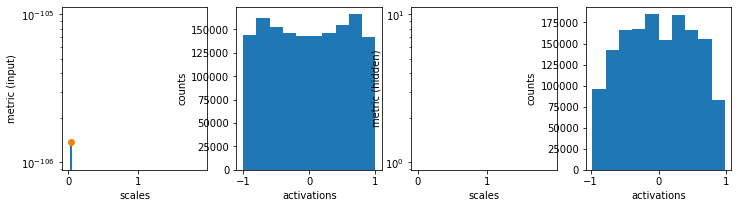

In [19]:
#optimal_weights_generator fitting
esn_bru_uv.fit(train_data_uv, inspect = True, initialization_strategy = optimal_weights_generator(
    verbose = 2,
    range_generator=np.linspace,
    steps = 100,
    hidden_std = 0.5,
    find_optimal_input = True,
    thinning_step = 10,
))

##### reservoir states 

In [20]:
esn_bru_uv = esn_bru_uv._get_reservoir_states(train_data_uv,inspect=True)

finding...


100%|███████████████████████████████████████████████████████████████████████████▉| 9999/10000 [00:15<00:00, 651.70it/s]


in skesn:

    def _get_reservoir_states(self, y, X=None,
             initialization_strategy=standart_weights_generator,
             inspect=False):
        """Need to know reservoir states?

        Parameters
        ----------
        y : array-like, shape (batch_size x n_timesteps x n_inputs)
            Time series to which to fit the forecaster
            or a sequence of them (batches).
        X : array-like or function, shape (batch_size x n_timesteps x n_controls), optional (default=None)
            Exogeneous time series to fit to or a sequence of them (batches).
            Can also be understood as a control signal
        initialization_strategy: function
            A function generating random matrices W_in, W and W_c
        inspect : bool
            Whether to show a visualisation of the collected reservoir states

        Returns
        -------
        self : returns an instance of self.
        """
        endo_states, exo_states = \
            self._treat_dimensions_and_bias(y, X, representation='3D')
        n_batches = endo_states.shape[0]
        n_timesteps = endo_states.shape[1]

        reservoir_states = np.zeros((n_batches, n_timesteps, self.n_reservoir))

        if inspect:
            print("finding...")
            pbar = tqdm(total=n_batches*n_timesteps,
                        position=0,
                        leave=True)

        for b in range(n_batches):
            for n in range(1, n_timesteps):
                if exo_states is None:
                    reservoir_states[b, n, :] = \
                        self._iterate_reservoir_state(reservoir_states[b, n - 1],
                                                      endo_states[b, n - 1, :])
                else:
                    reservoir_states[b, n, :] = \
                        self._iterate_reservoir_state(reservoir_states[b, n - 1],
                                                      endo_states[b, n - 1, :],
                                                      exo_states[b, n, :])
                if inspect:
                    pbar.update(1)
        if inspect:
            pbar.close()

        reservoir_states = np.reshape(reservoir_states,
                                      (-1, reservoir_states.shape[-1]))

        self.reservoir_states = reservoir_states 

        return self

In [13]:
print(esn_bru_uv.W_.shape)
print(esn_bru_uv.reservoir_states.shape)
esn_bru_uv.__dict__

(1500, 1500)
(10000, 1500)


{'n_reservoir': 1500,
 'spectral_radius': 0.95,
 'sparsity': 0.2,
 'regularization': 'noise',
 'lambda_r': 0.005,
 'use_additive_noise_when_forecasting': True,
 'in_activation': 'tanh',
 'out_activation': 'identity',
 'random_state': 10,
 'use_bias': True,
 'random_state_': RandomState(MT19937) at 0x2A2457DFC40,
 '_is_fitted': True,
 '_y': None,
 '_X': None,
 '_fh': None,
 '_cutoff': None,
 'W_in_': array([[ 0.54264129, -0.9584961 ,  0.26729647, ...,  0.61873467,
          0.60138801, -0.96618038],
        [ 0.72258865,  0.82260045, -0.19824663, ..., -0.51891718,
          0.21591462, -0.57205076],
        [-0.03263349, -0.11184285, -0.2704041 , ..., -0.08082618,
         -0.36531504, -0.09265377],
        ...,
        [ 0.25438592,  0.41647907, -0.22020297, ..., -0.74684258,
          0.62128426, -0.45218045],
        [ 0.16241257, -0.75815094, -0.1595115 , ...,  0.67476628,
          0.055225  ,  0.82025688],
        [ 0.24499998,  0.29091387,  0.20943894, ...,  0.00791699,
         

-0.974843036295891 0.976280450636263


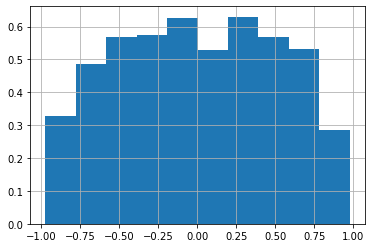

In [21]:
#reservoir states hist
newshape=np.prod(esn_bru_uv.reservoir_states.shape)
a = np.reshape(esn_bru_uv.reservoir_states, (newshape))
print(min(a), max(a))
plt.hist(a, density = True)#, bins = np.arange(min(a), max(a) + 0.04, 0.04), density = True)
plt.grid()
plt.show()

##### prediction

In [37]:
time_predict= u_v_concat.shape[0] - time_train #10000
prediction_uv = esn_bru_uv.predict(time_predict,inspect=True).T 
print(prediction_uv.shape)

predict...


100%|█████████████████████████████████████████████████████████████████████████████| 8001/8001 [00:18<00:00, 421.36it/s]


(512, 8001)


In [38]:
#разделяем предсказанное на u и v
u_pred = prediction_uv.T[:,:256]
v_pred = prediction_uv.T[:,256:]
t_step=0.01 * t_miss
t_pred = np.arange(20+t_step*time_train, 20+t_step*(time_train+time_predict), t_step)
print(u_pred.shape)
print(v_pred.shape)
print(t_pred.shape)

(8001, 256)
(8001, 256)
(8001,)


In [ ]:
#графики:

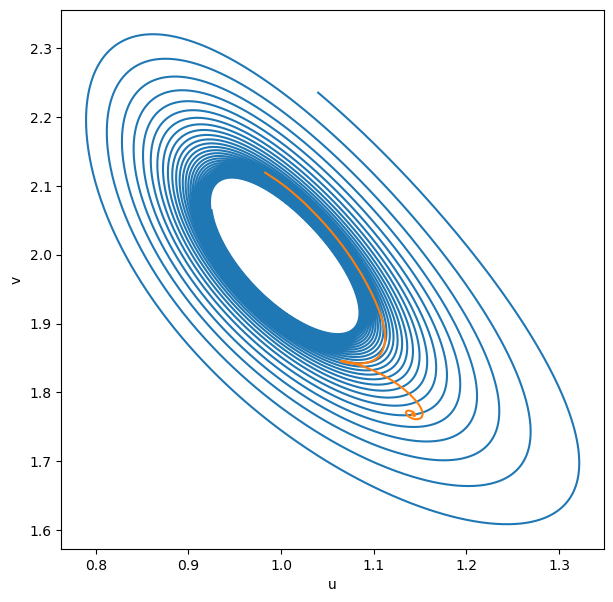

In [39]:
fig, ax = plt.subplots( figsize=(7, 7))
start =  0 # 9900 #
end = 18000 # 10100 # 
start_p = 0
end_p = 10000
plt.plot(u[start:end,2],v_new[start:end,2])
plt.plot(u_pred[start_p:end_p, 2], v_pred[start_p:end_p, 2])
plt.xlabel("u", fontsize=16)
plt.ylabel("v", fontsize=16)
#plt.savefig("C:\\Users\\njuro\\Documents\\Диплом Магистратура\\Figures\\1D_bru_images_note_08_26\\phase_tr_2_0003.png")
plt.show()

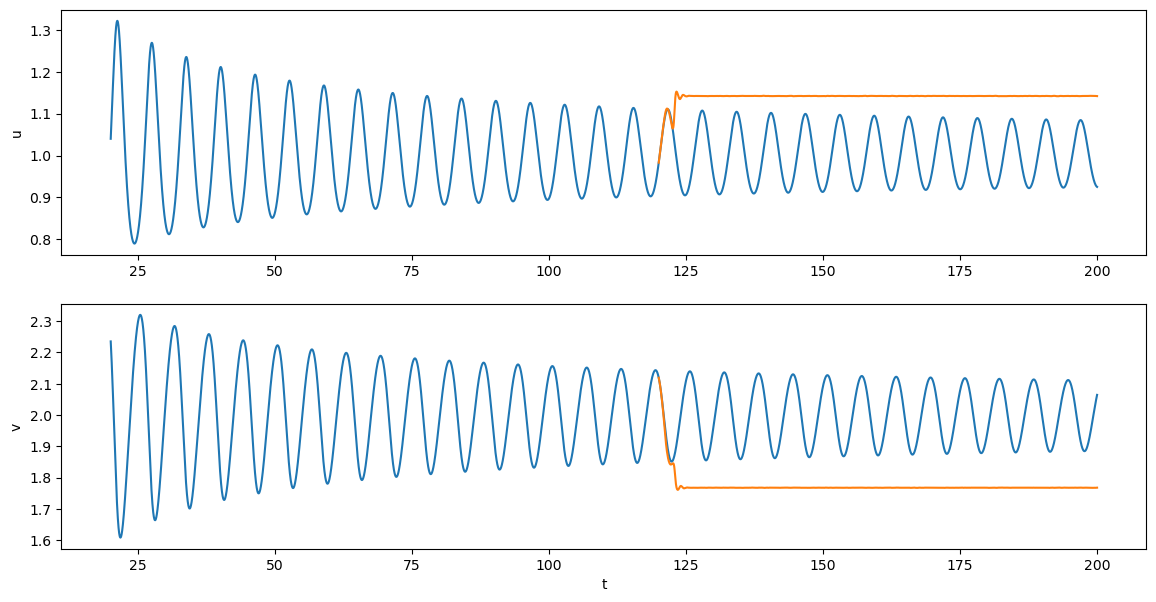

In [41]:
fig, ax = plt.subplots(2,1, figsize=(14, 7))
start = 0#  9990 # 
end =  18000# 12000  # 
start_p = 0
end_p = 8000 # 10000# 120 #
ax[0].plot(t[start:end:t_miss],u[start:end:t_miss,2])
ax[0].plot(t_pred[start_p:end_p], u_pred[start_p:end_p, 2])
ax[0].set_ylabel("u", fontsize=16)
ax[1].plot(t[start:end:t_miss],v_new[start:end:t_miss,2])
ax[1].plot(t_pred[start_p:end_p], v_pred[start_p:end_p, 2])
ax[1].set_ylabel("v", fontsize=16)
plt.xlabel("t", fontsize=16)
#plt.savefig("C:\\Users\\njuro\\Documents\\Диплом Магистратура\\Figures\\1D_bru_images_note_08_26\\u_v_ot_t_0003.png")
plt.show()

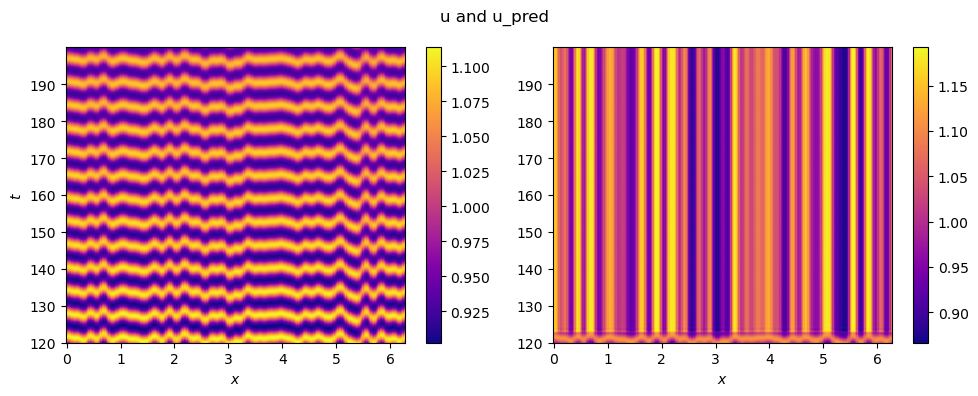

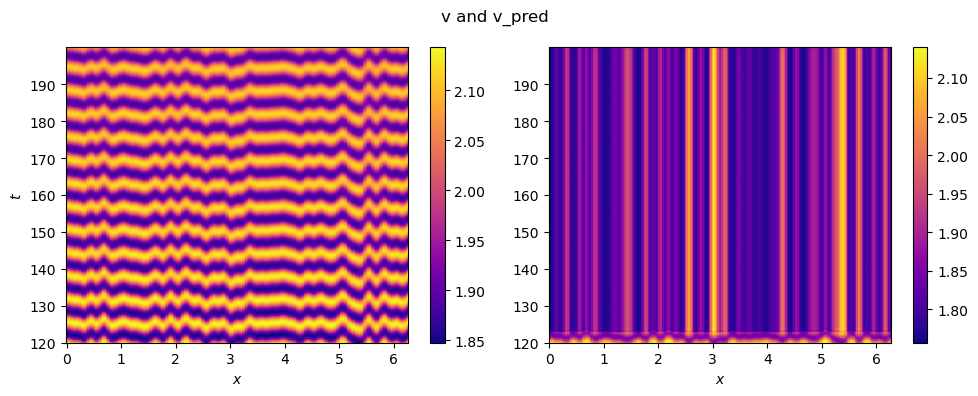

In [42]:
#предсказанное colormesh u
fig, ax = plt.subplots(1,2, figsize=(10, 4))
p1 = ax[0].pcolormesh(x, t[10000:-1], u[10000:-1,:], shading='nearest',cmap='plasma')
p2 = ax[1].pcolormesh(x, t_pred[:8000], u_pred[:8000,:], shading='nearest',cmap='plasma')
ax[0].set_xlabel(r'$x$', fontsize=16)
ax[1].set_xlabel(r'$x$', fontsize=16)
ax[0].set_ylabel(r'$t$', fontsize=16)
fig.colorbar(p1, ax=ax[0])
fig.colorbar(p2, ax=ax[1])
plt.suptitle("u and u_pred")
plt.tight_layout()
#plt.ylim([175,200])
#plt.savefig("C:\\Users\\njuro\\Documents\\Диплом Магистратура\\Figures\\1D_bru_images_note_08_15\\u_pred_colormesh_2_0002.png")
plt.show()

#предсказанное colormesh v
fig, ax = plt.subplots(1,2, figsize=(10, 4))
p1 = ax[0].pcolormesh(x, t[10000:-1], v_new[10000:-1,:], shading='nearest',cmap='plasma')
p2 = ax[1].pcolormesh(x, t_pred[:8000], v_pred[:8000,:], shading='nearest',cmap='plasma')
ax[0].set_xlabel(r'$x$', fontsize=16)
ax[1].set_xlabel(r'$x$', fontsize=16)
ax[0].set_ylabel(r'$t$', fontsize=16)
fig.colorbar(p1, ax=ax[0])
fig.colorbar(p2, ax=ax[1])
plt.suptitle("v and v_pred")
plt.tight_layout()
#plt.ylim([175,200])
#plt.savefig("C:\\Users\\njuro\\Documents\\Диплом Магистратура\\Figures\\1D_bru_images_note_08_15\\u_pred_colormesh_2_0002.png")
plt.show()

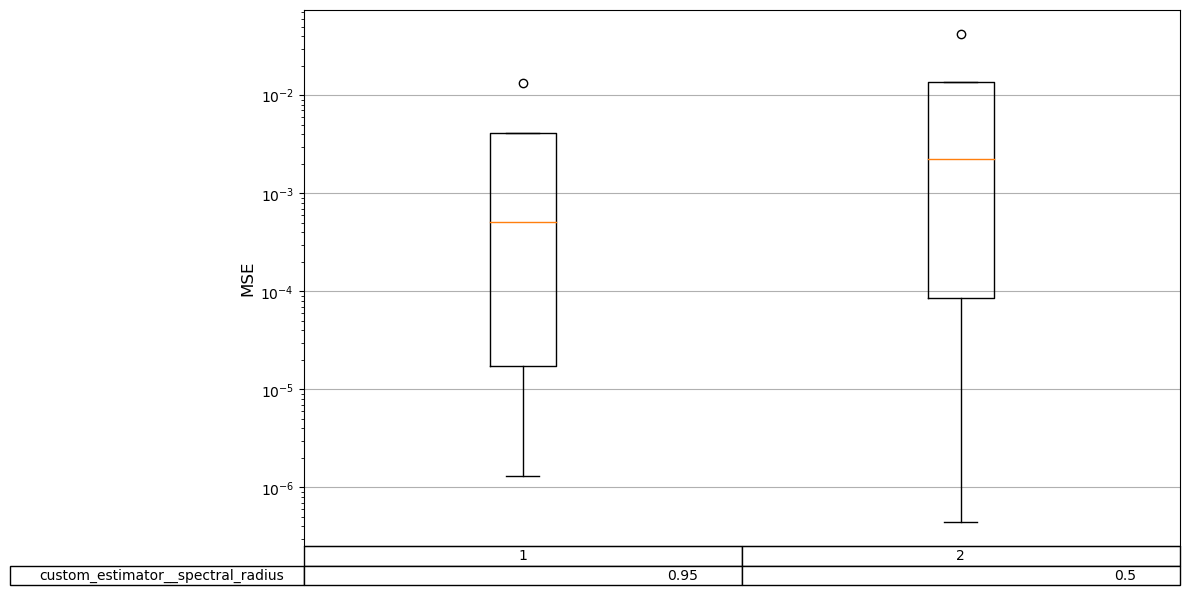

In [9]:
# Plot hyperparameter grid search results based on rolling forecasting origin
test_time_length = 2
esn_dt = 0.01
n_splits = 4
v = ValidationBasedOnRollingForecastingOrigin(n_training_timesteps=None,
                                              n_test_timesteps=int(test_time_length / esn_dt),
                                              n_splits=n_splits,
                                              metric=mean_squared_error,
                                              initialization_strategy = optimal_weights_generator(
                                                                            verbose = 2,
                                                                            range_generator=np.linspace,
                                                                            steps = 100,
                                                                            hidden_std = 0.5,
                                                                            find_optimal_input = True,
                                                                            thinning_step = 10,
                                                                        )
                                             )
summary, best_model = v.grid_search(esn_bru_uv,
                                    param_grid=dict(
                                        spectral_radius=[0.5, 0.95],
                                 #       sparsity=[0.0, 0.2, 0.8],
                                 #       lambda_r= [0.01, 0.005, 0.001] #[0.01, 0.001, 0.0001]
                                        ),
                                    y=u_v_concat,
                                    X=None)
summary_df = pd.DataFrame(summary).sort_values('rank_test_score')
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
table_rows = []
param_names = list(summary_df.iloc[0]['params'].keys())
ranks = []
test_scores = []
for i in range(len(summary_df)):
    ranks.append(int(summary_df.iloc[i]['rank_test_score']))
    table_rows.append(list(summary_df.iloc[i]['params'].values()))
    test_scores.append(np.abs(np.array([float(summary_df.iloc[i][f'split{j}_test_score']) for j in range(n_splits)])))
ax.boxplot(test_scores)
ax.set_yscale('log')
ax.set_xticks([])
ax.set_ylabel('MSE', fontsize=12)
ax.grid()
table_rows = [*zip(*table_rows)]
the_table = ax.table(cellText=table_rows,
                     rowLabels=param_names,
                     colLabels=ranks,
                     loc='bottom')
plt.tight_layout()
plt.show()

in cross_validation:

    from skesn.weight_generators import standart_weights_generator ###<<<
    def __init__(self, metric=mean_absolute_percentage_error,
                 n_training_timesteps=None,
                 n_test_timesteps=10,
                 n_splits=10,
                 initialization_strategy=standart_weights_generator): ###<<<
        self.metric = metric
        self.n_training_timesteps = n_training_timesteps
        self.n_test_timesteps = n_test_timesteps
        self.n_splits = n_splits
        self.initialization_strategy=initialization_strategy ###<<<
        
     def grid_search(self, forecaster, param_grid, y, X):
         ...
         grid.fit(X=X, y=y, initialization_strategy=self.initialization_strategy) ###<<<
         

In [10]:
import winsound
frequency = 500  # Set Frequency To 2500 Hertz
duration = 100  # Set Duration To 1000 ms == 1 second
#winsound.Beep(frequency*10, duration)
winsound.Beep(frequency, duration)